<a href="https://colab.research.google.com/github/MuzammilAshraf09/DEMO/blob/main/Muz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ultralytics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.2/887.2 kB 10.9 MB/s eta 0:00:00


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 90s 3s/step - accuracy: 0.5231 - loss: 0.7042 - val_accuracy: 0.4444 - val_loss: 0.7030 - learning_rate: 1.0000e-04
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 77s 3s/step - accuracy: 0.5743 - loss: 0.6831 - val_accuracy: 0.4444 - val_loss: 0.6855 - learning_rate: 1.0000e-04
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.6735 - loss: 0.6349 - val_accuracy: 0.5926 - val_loss: 0.6321 - learning_rate: 1.0000e-04
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - accuracy: 0.5983 - loss: 0.6558 - val_accuracy: 0.5926 - val_loss: 0.6086 - learning_rate: 1.0000e-04
Epoch 5/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 77s 3s/step - accuracy: 0.6261 - loss: 0.6210 - val_accuracy: 0.7778 - val_loss: 0.5901 - learning_rate: 1.0000e-04
Epoch 6/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 76s 3s/step - accuracy: 0.7233 - loss: 0.5682 - val_accuracy: 0

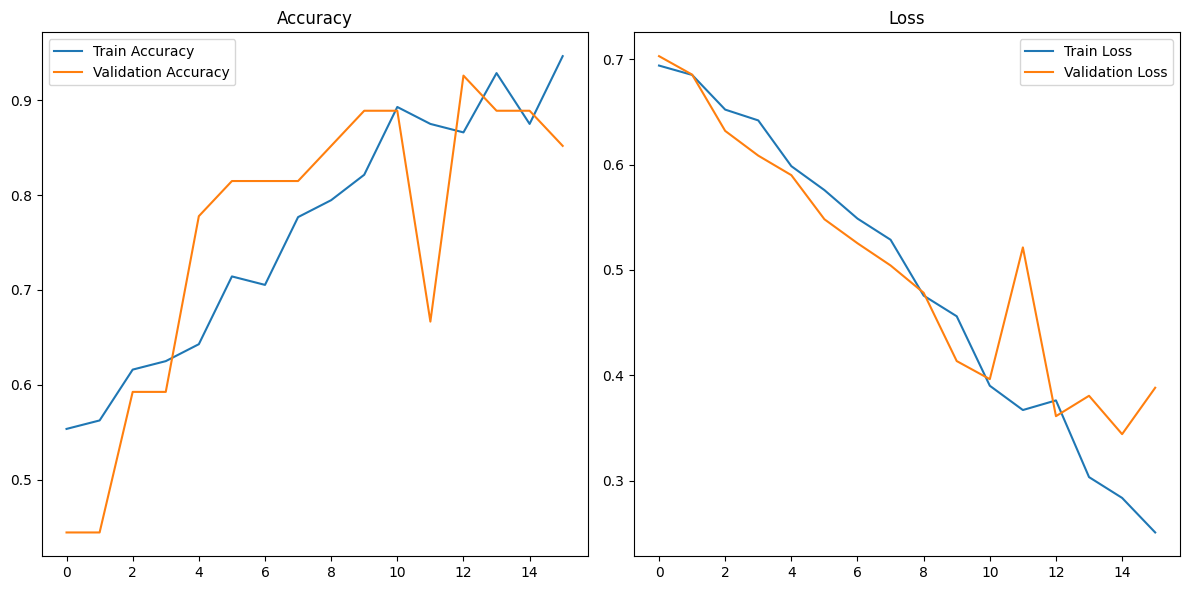


0: 384x640 1 person, 1 bed, 218.9ms
Speed: 3.1ms preprocess, 218.9ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 bed, 204.5ms
Speed: 3.1ms preprocess, 204.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 217.1ms
Speed: 3.1ms preprocess, 217.1ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 bed, 217.7ms
Speed: 3.4ms preprocess, 217.7ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 213.8ms
Speed: 3.6ms preprocess, 213.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 246.8ms
Speed: 4.0ms preprocess, 246.8ms inference, 6.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 bed, 714.0ms
Speed: 10.1ms preprocess, 714.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 227.2ms
Speed: 3.1ms preprocess, 227.2ms inference, 6

In [ ]:
# Import necessary libraries
from google.colab import drive
drive.mount('/content/drive')

# Install required libraries
!pip install tensorflow opencv-python-headless matplotlib ultralytics

import tensorflow as tf
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Dropout, TimeDistributed,
    BatchNormalization, Attention, Input
)
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import cv2
import numpy as np
import os
from glob import glob
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Step 1: Define the CNN-LSTM model with attention mechanism
def build_model(input_shape):
    inputs = Input(shape=input_shape)

    # CNN layers
    x = TimeDistributed(Conv2D(64, (3, 3), activation='relu'))(inputs)
    x = TimeDistributed(BatchNormalization())(x)
    x = TimeDistributed(MaxPooling2D((2, 2)))(x)

    x = TimeDistributed(Conv2D(128, (3, 3), activation='relu'))(x)
    x = TimeDistributed(BatchNormalization())(x)
    x = TimeDistributed(MaxPooling2D((2, 2)))(x)

    x = TimeDistributed(Conv2D(256, (3, 3), activation='relu'))(x)
    x = TimeDistributed(BatchNormalization())(x)
    x = TimeDistributed(MaxPooling2D((2, 2)))(x)

    x = TimeDistributed(Flatten())(x)

    # Attention mechanism
    attention_out = Attention()([x, x])

    # LSTM layers
    lstm_out = LSTM(128, return_sequences=True)(attention_out)
    lstm_out = LSTM(64)(lstm_out)

    # Fully connected layers
    x = Dense(128, activation='relu')(lstm_out)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)

    # Output layer
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Step 2: Data preprocessing
def preprocess_frame(frame, target_size=(64, 64)):
    frame = cv2.resize(frame, target_size)
    return frame / 255.0  # Normalize pixel values

def load_video_data(path, label, sequence_length):
    sequences, labels = [], []
    for video_path in glob(os.path.join(path, "*.mp4")):
        cap = cv2.VideoCapture(video_path)
        frames = []
        while len(frames) < sequence_length:
            ret, frame = cap.read()
            if not ret:
                break
            frames.append(preprocess_frame(frame))
        cap.release()
        if len(frames) == sequence_length:
            sequences.append(frames)
            labels.append(label)
    return np.array(sequences), np.array(labels)

# Step 3: Load datasets
def load_datasets(train_paths, val_paths, sequence_length):
    X_train, y_train, X_val, y_val = [], [], [], []

    for path, label in train_paths:
        X, y = load_video_data(path, label, sequence_length)
        X_train.append(X)
        y_train.append(y)

    for path, label in val_paths:
        X, y = load_video_data(path, label, sequence_length)
        X_val.append(X)
        y_val.append(y)

    X_train, y_train = np.concatenate(X_train), np.concatenate(y_train)
    X_val, y_val = np.concatenate(X_val), np.concatenate(y_val)

    return (X_train, y_train), (X_val, y_val)

# Define paths for training and validation datasets
train_paths = [
    ("/content/drive/MyDrive/datasetvideo/train/fall", 1),
    ("/content/drive/MyDrive/datasetvideo/train/nofall", 0)
]
val_paths = [
    ("/content/drive/MyDrive/datasetvideo/val/fall", 1),
    ("/content/drive/MyDrive/datasetvideo/val/nofall", 0)
]
sequence_length = 10  # Number of frames in a sequence

# Load the datasets
(X_train, y_train), (X_val, y_val) = load_datasets(train_paths, val_paths, sequence_length)

# Shuffle the datasets
train_indices = np.random.permutation(len(X_train))
X_train, y_train = X_train[train_indices], y_train[train_indices]
val_indices = np.random.permutation(len(X_val))
X_val, y_val = X_val[val_indices], y_val[val_indices]

# Step 4: Train the model
input_shape = (sequence_length, 64, 64, 3)
model = build_model(input_shape)

callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5, min_lr=1e-5)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=4,
    callbacks=callbacks
)

# Save the trained model
model.save('/content/drive/MyDrive/fall_detection_model.keras')

# Step 5: Evaluate the model
def evaluate_model(test_paths, model, sequence_length):
    X_test, y_test = [], []
    for path, label in test_paths:
        X, y = load_video_data(path, label, sequence_length)
        X_test.append(X)
        y_test.append(y)
    X_test, y_test = np.concatenate(X_test), np.concatenate(y_test)
    indices = np.random.permutation(len(X_test))
    X_test, y_test = X_test[indices], y_test[indices]
    return model.evaluate(X_test, y_test)

test_paths = [
    ("/content/drive/MyDrive/datasetvideo/test/fall", 1),
    ("/content/drive/MyDrive/datasetvideo/test/nofall", 0)
]

test_loss, test_accuracy = evaluate_model(test_paths, model, sequence_length)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Step 6: Visualize training history
def plot_history(history):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)

# Step 7: Fall detection function
def detect_falls(model, input_path, output_path, sequence_length):
    """
    Detect falls in a video using a trained model and YOLO for person detection.

    Args:
        model: Trained TensorFlow model for fall detection.
        input_path: Path to the input video.
        output_path: Path to save the output video with detections.
        sequence_length: Number of frames in a sequence for fall detection.
    """
    # Load the video
    cap = cv2.VideoCapture(input_path)
    if not cap.isOpened():
        print(f"Error: Unable to open video {input_path}")
        return

    # Video properties
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))

    # Output video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    # Load YOLOv8 model
    yolo_model = YOLO('yolov8n.pt')  # Lightweight YOLOv8 model

    # Sequence buffer for fall detection
    frames = []

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Use YOLOv8 to detect persons
        results = yolo_model(frame)
        detections = results[0].boxes

        for detection in detections:
            if detection.cls == 0:  # Class 0 corresponds to 'person'
                # Extract bounding box coordinates
                coords = detection.xyxy.cpu().numpy().astype(int)[0]
                x1, y1, x2, y2 = coords

                # Draw bounding box
                cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)

                # Extract and preprocess the detected person
                person_frame = frame[y1:y2, x1:x2]
                processed_frame = preprocess_frame(person_frame)
                frames.append(processed_frame)

                # If enough frames are collected, predict fall
                if len(frames) == sequence_length:
                    # Prepare the sequence for prediction
                    frames_sequence = np.array(frames).reshape(1, sequence_length, 64, 64, 3)
                    prediction = model.predict(frames_sequence)

                    # Check if the prediction indicates a fall
                    if prediction >= 0.55:
                        cv2.putText(frame, "Fall Detected", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

                    frames.pop(0)  # Remove the oldest frame to maintain the sequence length

        # Write the processed frame to the output video
        out.write(frame)

    # Release resources
    cap.release()
    out.release()

# Step 8: Apply fall detection to an input video
input_video = '/content/drive/MyDrive/test.mp4'
output_video = '/content/drive/MyDrive/fall_detection_output.mp4'
sequence_length = 10  # Number of frames for sequence

detect_falls(model, input_video, output_video, sequence_length)


In [ ]:
def detect_falls(model, input_path, output_path, sequence_length):
    """
    Detect falls in a video using a trained model and YOLO for person detection.

    Args:
        model: Trained TensorFlow model for fall detection.
        input_path: Path to the input video.
        output_path: Path to save the output video with detections.
        sequence_length: Number of frames in a sequence for fall detection.
    """
    # Load the video
    cap = cv2.VideoCapture(input_path)
    if not cap.isOpened():
        print(f"Error: Unable to open video {input_path}")
        return

    # Video properties
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))

    # Output video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    # Load YOLOv8 model
    yolo_model = YOLO('yolov8n.pt')  # Lightweight YOLOv8 model

    # Sequence buffer for fall detection
    frames = []

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Use YOLOv8 to detect persons
        results = yolo_model(frame)
        detections = results[0].boxes

        for detection in detections:
            if detection.cls == 0:  # Class 0 corresponds to 'person'
                # Extract bounding box coordinates
                coords = detection.xyxy.cpu().numpy().astype(int)[0]
                x1, y1, x2, y2 = coords

                # Draw bounding box
                cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)

                # Extract and preprocess the detected person
                person_frame = frame[y1:y2, x1:x2]
                processed_frame = preprocess_frame(person_frame)
                frames.append(processed_frame)

                # If enough frames are collected, predict fall
                if len(frames) == sequence_length:
                    # Prepare the sequence for prediction
                    frames_sequence = np.array(frames).reshape(1, sequence_length, 64, 64, 3)
                    prediction = model.predict(frames_sequence)

                    # Check if the prediction indicates a fall
                    if prediction >= 0.76669:
                        cv2.putText(frame, "Fall Detected", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

                    frames.pop(0)  # Remove the oldest frame to maintain the sequence length

        # Write the processed frame to the output video
        out.write(frame)

    # Release resources
    cap.release()
    out.release()

# Step 8: Apply fall detection to an input video
input_video = '/content/drive/MyDrive/Copy of FallSittingS10.avi'
output_video = '/content/drive/MyDrive/fall_detection_output3.avi'
sequence_length = 10  # Number of frames for sequence

detect_falls(model, input_video, output_video, sequence_length)



0: 448x640 1 person, 1 chair, 2 tvs, 145.8ms
Speed: 3.2ms preprocess, 145.8ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 1 chair, 1 tv, 135.5ms
Speed: 2.9ms preprocess, 135.5ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 1 chair, 1 tv, 146.5ms
Speed: 2.9ms preprocess, 146.5ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 1 chair, 1 tv, 148.7ms
Speed: 3.8ms preprocess, 148.7ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 1 chair, 1 tv, 133.7ms
Speed: 4.1ms preprocess, 133.7ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 1 chair, 1 tv, 138.2ms
Speed: 4.1ms preprocess, 138.2ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 1 chair, 1 tv, 137.5ms
Speed: 3.2ms preprocess, 137.5ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640

In [ ]:
# Import necessary libraries
from google.colab import drive
drive.mount('/content/drive')

# Install required libraries
!pip install tensorflow opencv-python-headless matplotlib ultralytics

import tensorflow as tf
from tensorflow.keras.layers import (
    TimeDistributed, LSTM, Dense, Dropout, Attention, Flatten, BatchNormalization, Input
)
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import cv2
import numpy as np
import os
from glob import glob
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Step 1: Define the CNN-LSTM model with pretrained layers and attention mechanism
def build_model(input_shape, sequence_length):
    inputs = Input(shape=(sequence_length,) + input_shape)

    # Pretrained base model (MobileNetV2)
    base_model = MobileNetV2(include_top=False, input_shape=input_shape, weights='imagenet')
    base_model.trainable = False  # Freeze pretrained layers

    # Apply base model to each frame in the sequence using TimeDistributed
    x = TimeDistributed(base_model)(inputs)
    x = TimeDistributed(Flatten())(x)

    # Attention mechanism
    attention_out = Attention()([x, x])

    # LSTM layers
    lstm_out = LSTM(128, return_sequences=True)(attention_out)
    lstm_out = LSTM(64)(lstm_out)

    # Fully connected layers
    x = Dense(128, activation='relu')(lstm_out)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)

    # Output layer
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Step 2: Data preprocessing
def preprocess_frame(frame, target_size=(224, 224)):
    frame = cv2.resize(frame, target_size)
    return frame / 255.0  # Normalize pixel values

def load_video_data(path, label, sequence_length, input_size):
    sequences, labels = [], []
    for video_path in glob(os.path.join(path, "*.mp4")):
        cap = cv2.VideoCapture(video_path)
        frames = []
        while len(frames) < sequence_length:
            ret, frame = cap.read()
            if not ret:
                break
            frames.append(preprocess_frame(frame, target_size=input_size[:2]))
        cap.release()
        if len(frames) == sequence_length:
            sequences.append(frames)
            labels.append(label)
    return np.array(sequences), np.array(labels)

# Step 3: Load datasets
def load_datasets(train_paths, val_paths, sequence_length, input_size):
    X_train, y_train, X_val, y_val = [], [], [], []

    for path, label in train_paths:
        X, y = load_video_data(path, label, sequence_length, input_size)
        X_train.append(X)
        y_train.append(y)

    for path, label in val_paths:
        X, y = load_video_data(path, label, sequence_length, input_size)
        X_val.append(X)
        y_val.append(y)

    X_train, y_train = np.concatenate(X_train), np.concatenate(y_train)
    X_val, y_val = np.concatenate(X_val), np.concatenate(y_val)

    return (X_train, y_train), (X_val, y_val)

# Define paths for training and validation datasets
train_paths = [
    ("/content/drive/MyDrive/datasetvideo/train/fall", 1),
    ("/content/drive/MyDrive/datasetvideo/train/nofall", 0)
]
val_paths = [
    ("/content/drive/MyDrive/datasetvideo/val/fall", 1),
    ("/content/drive/MyDrive/datasetvideo/val/nofall", 0)
]
sequence_length = 10  # Number of frames in a sequence
input_size = (224, 224, 3)

# Load the datasets
(X_train, y_train), (X_val, y_val) = load_datasets(train_paths, val_paths, sequence_length, input_size)

# Shuffle the datasets
train_indices = np.random.permutation(len(X_train))
X_train, y_train = X_train[train_indices], y_train[train_indices]
val_indices = np.random.permutation(len(X_val))
X_val, y_val = X_val[val_indices], y_val[val_indices]

# Step 4: Train the model
input_shape = input_size
model = build_model(input_shape, sequence_length)

callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5, min_lr=1e-5)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=4,
    callbacks=callbacks
)

# Save the trained model
model.save('/content/drive/MyDrive/fall_detection_model_with_pretrained.keras')

# Step 5: Evaluate the model
def evaluate_model(test_paths, model, sequence_length, input_size):
    X_test, y_test = [], []
    for path, label in test_paths:
        X, y = load_video_data(path, label, sequence_length, input_size)
        X_test.append(X)
        y_test.append(y)
    X_test, y_test = np.concatenate(X_test), np.concatenate(y_test)
    indices = np.random.permutation(len(X_test))
    X_test, y_test = X_test[indices], y_test[indices]
    return model.evaluate(X_test, y_test)

test_paths = [
    ("/content/drive/MyDrive/datasetvideo/test/fall", 1),
    ("/content/drive/MyDrive/datasetvideo/test/nofall", 0)
]

test_loss, test_accuracy = evaluate_model(test_paths, model, sequence_length, input_size)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 896.3/896.3 kB 19.1 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 174s 5s/step - accuracy: 0.3716 - loss: 0.7160 - val_accuracy: 0.4815 - val_loss: 0.6873 - learning_rate: 1.0000e-04
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 136s 4s/step - accuracy: 0.5194 - loss: 0.6958 - val_accuracy: 0.5556 - val_loss: 0.6919 - learning_rate: 1.0000e-04
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 120s 4s/step - accuracy: 0.4820 - loss: 0.7204 - val_accuracy: 0.6667 - val_loss: 

In [ ]:
# Step 1: Define the CNN-LSTM model with pretrained layers (EfficientNetB0) and attention mechanism
def build_model(input_shape, sequence_length):
    inputs = Input(shape=(sequence_length,) + input_shape)  # Input shape for video frames

    # Pretrained base model (EfficientNetB0 for feature extraction)
    base_model = EfficientNetB0(include_top=False, input_shape=input_shape, weights='imagenet')
    base_model.trainable = False  # Freeze the pretrained layers for feature extraction

    # Apply base model to each frame in the sequence using TimeDistributed
    x = TimeDistributed(base_model)(inputs)
    x = TimeDistributed(Flatten())(x)  # Flatten the output for further processing

    # Custom CNN Layers after EfficientNetB0
    x = TimeDistributed(Conv2D(64, (3, 3), activation='relu'))(x)
    x = TimeDistributed(BatchNormalization())(x)
    x = TimeDistributed(MaxPooling2D((2, 2)))(x)

    x = TimeDistributed(Conv2D(128, (3, 3), activation='relu'))(x)
    x = TimeDistributed(BatchNormalization())(x)
    x = TimeDistributed(MaxPooling2D((2, 2)))(x)

    x = TimeDistributed(Conv2D(256, (3, 3), activation='relu'))(x)
    x = TimeDistributed(BatchNormalization())(x)
    x = TimeDistributed(MaxPooling2D((2, 2)))(x)

    # Flatten the output for LSTM
    x = TimeDistributed(Flatten())(x)

    # Attention mechanism to focus on important frames
    attention_out = Attention()([x, x])

    # LSTM layers for temporal sequence processing
    lstm_out = LSTM(128, return_sequences=True)(attention_out)
    lstm_out = LSTM(64)(lstm_out)  # Second LSTM layer for encoding the sequence

    # Fully connected layers (Dense)
    x = Dense(128, activation='relu')(lstm_out)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)

    # Output layer for binary classification (fall or no fall)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Step 2: Data preprocessing for video frames
def preprocess_frame(frame, target_size=(224, 224)):
    frame = cv2.resize(frame, target_size)  # Resize frame to target size
    return frame / 255.0  # Normalize pixel values to [0, 1]

def load_video_data(path, label, sequence_length, input_size):
    sequences, labels = [], []
    for video_path in glob(os.path.join(path, "*.mp4")):
        cap = cv2.VideoCapture(video_path)
        frames = []
        while len(frames) < sequence_length:
            ret, frame = cap.read()
            if not ret:
                break
            frames.append(preprocess_frame(frame, target_size=input_size[:2]))
        cap.release()
        if len(frames) == sequence_length:
            sequences.append(frames)
            labels.append(label)
    return np.array(sequences), np.array(labels)

# Step 3: Load datasets for training and validation
def load_datasets(train_paths, val_paths, sequence_length, input_size):
    X_train, y_train, X_val, y_val = [], [], [], []

    for path, label in train_paths:
        X, y = load_video_data(path, label, sequence_length, input_size)
        X_train.append(X)
        y_train.append(y)

    for path, label in val_paths:
        X, y = load_video_data(path, label, sequence_length, input_size)
        X_val.append(X)
        y_val.append(y)

    X_train, y_train = np.concatenate(X_train), np.concatenate(y_train)
    X_val, y_val = np.concatenate(X_val), np.concatenate(y_val)

    return (X_train, y_train), (X_val, y_val)

# Define paths for training and validation datasets
train_paths = [
    ("/content/drive/MyDrive/datasetvideo/train/fall", 1),
    ("/content/drive/MyDrive/datasetvideo/train/nofall", 0)
]
val_paths = [
    ("/content/drive/MyDrive/datasetvideo/val/fall", 1),
    ("/content/drive/MyDrive/datasetvideo/val/nofall", 0)
]
sequence_length = 10  # Number of frames in a sequence
input_size = (224, 224, 3)  # Input size for frames

# Load the datasets
(X_train, y_train), (X_val, y_val) = load_datasets(train_paths, val_paths, sequence_length, input_size)

# Shuffle the datasets
train_indices = np.random.permutation(len(X_train))
X_train, y_train = X_train[train_indices], y_train[train_indices]
val_indices = np.random.permutation(len(X_val))
X_val, y_val = X_val[val_indices], y_val[val_indices]

# Step 4: Train the model
input_shape = input_size
model = build_model(input_shape, sequence_length)

callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5, min_lr=1e-5)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=4,
    callbacks=callbacks
)

# Save the trained model
model.save('/content/drive/MyDrive/fall_detection_model_with_custom_layers.keras')

# Step 5: Plot training and validation accuracy/loss
plt.figure(figsize=(12, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Step 6: Evaluate the model on the test set
def evaluate_model(test_paths, model, sequence_length, input_size):
    X_test, y_test = [], []
    for path, label in test_paths:
        X, y = load_video_data(path, label, sequence_length, input_size)
        X_test.append(X)
        y_test.append(y)
    X_test, y_test = np.concatenate(X_test), np.concatenate(y_test)
    indices = np.random.permutation(len(X_test))
    X_test, y_test = X_test[indices], y_test[indices]
    return model.evaluate(X_test, y_test)

test_paths = [
    ("/content/drive/MyDrive/datasetvideo/test/fall", 1),
    ("/content/drive/MyDrive/datasetvideo/test/nofall", 0)
]

test_loss, test_accuracy = evaluate_model(test_paths, model, sequence_length, input_size)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


NameError: name 'Conv2D' is not defined